# Adaptive Search: Changing `search_range` on the Fly

As discussed in the tutorial on "Advanced Linking," a basic limitation of the tracking algorithm involves the selection of `search_range`. If it is too small, many valid trajectories will be unlinked or linked incorrectly. If it is too large, `trackpy` will become overwhelmed with candidate features, and will either be bogged down by those possibilities or will give up entirely, raising a `SubnetOversizeException`. 

The tutorial on "Advanced Linking" identifies some ways to ease this dilemma, including prediction, which lets `trackpy` select candidate features more intelligently. Still, "perfect" tracking is often computationally impossible. One is then faced with the task of finding a `search_range` that allows linking to finish in a reasonable amount of time while merely *minimizing* linking errors. The usual method for optimizing `search_range` is to repeatedly adjust it and run the linker, searching for the largest value that does not halt or intolerably slow the algorithm. This search can be time-consuming and frustrating, especially for long movies. Perhaps worse, one must choose the `search_range` for all particles in all frames, even if the failure is being caused by a single large subnet spanning just two successive frames.

This difficulty is addressed by the "adaptive search" functionality that is built into `trackpy` starting with version 0.3. Instead of specifying a single `search_range` for all particles in all frames, one gives `trackpy` a *maximum* value. `trackpy` then automatically reduces `search_range` *only* when and where it encounters difficulty. 

## How it works

When it encounters a large subnet, the algorithm repeatedly attempts to link *only those particles*, using smaller and smaller values of `search_range`. As `search_range` is reduced, some of the possible track assignments are eliminated from consideration. The original large subnet is thereby broken up into smaller pieces, some of which may be small enough to solve directly (by considering all possible track assignments). This process continues until no oversize subnet(s) remain, or a minimum `search_range` is reached. In the latter case, a `SubnetOversizeException` is raised and linking is aborted.

## How to use it

To any of the `link` family of functions, supply the `search_range` argument as usual, along with an `adaptive_stop` argument, and optionally an `adaptive_step`. When `trackpy` encounters a large subnet, it will locally reduce `search_range` by multiplying it by `adaptive_step`. (`adaptive_step` must be greater than 0 and less than 1; the default is 0.95.) This multiplication will be applied repeatedly if necessary. `adaptive_stop` (note the single-letter difference!) tells `trackpy` when to give up. When `search_range` has become less than or equal to `adaptive_stop`, `trackpy` aborts linking by raising a `SubnetOversizeException`.

For example, at the high end, you might consider 10.0 to be a generous but reasonable `search_range` for your movie. At the low end, you feel that a `search_range` of 2.0 — the radius of one of your particles — is unreasonably small and would be a sure sign of trouble. Finally, you decide that `search_range` should be reduced carefully — just 5% at a time. The values you should specify are then

In [1]:
{'search_range': 10.0,
 'adaptive_stop': 2.0,
 'adaptive_step': 0.95}

{'adaptive_step': 0.95, 'adaptive_stop': 2.0, 'search_range': 10.0}

### The maximum subnet size, and a word of caution

There is one more parameter that you *may* wish to adjust, but the reason is a little technical. 

Under normal circumstances, if you have a movie that does *not* cry out for adaptive search, large subnets will be rare, and to get the most accurate linking you will want the computer to solve them all, even ones that take a few minutes. This favors a default maximum subnet size, stored in `trackpy.linking.Linker.MAX_SUB_NET_SIZE`, that is rather generous.

This situation changes when adaptive search is enabled. As it reduces `search_range`, `trackpy` is searching for the largest computable subnet(s) embedded within the original oversize, non-computable subnet. If you are lazy (and who isn't?), you will want to choose a generous (but reasonable) maximum `search_range` and let `trackpy` do the hard work of optimizing it downward. The result is that `trackpy` will frequently be solving subnets that are just below the maximum size. This favors a *small* maximum size, corresponding to a subnet that can be solved in well under a second.

Because a different behavior is desired in each case, there is a different default subnet limit for adaptive search, stored in `trackpy.linking.Linker.MAX_SUB_NET_SIZE_ADAPTIVE`. As with the regular default, you may wish to adjust this value depending on your patience and the speed of your computer.

The default values in the current version of `trackpy` are

In [2]:
import trackpy
import pandas as pd
import numpy as np
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline
from matplotlib.pyplot import *   # not recommended usage, but we use it for brevity here

trackpy.linking.Linker.MAX_SUB_NET_SIZE

30

In [3]:
trackpy.linking.Linker.MAX_SUB_NET_SIZE_ADAPTIVE

15

Since subnet computation time scales very roughly as $N!$, this is actually a *huge* difference in speed:

In [4]:
import math
float(math.factorial(trackpy.linking.Linker.MAX_SUB_NET_SIZE) / \
    math.factorial(trackpy.linking.Linker.MAX_SUB_NET_SIZE_ADAPTIVE))

2.0284320493172736e+20

The difference in maximal subnet size is the primary drawback of adaptive search. Solving a large subnet may be slow, but at least you are getting the best possible set of trajectories, ones that minimize the total displacement over all particles. (For details, see the original paper by Crocker & Grier, referenced in the introduction to the `trackpy` documentation.) Depending on the details of your movie, if you insist on solving smaller subnets you may instead get results that are less than fully correct.

**In other words,** adaptive search can abolish a lot of headaches, tedium, and gut-wrenching decisions, but it cannot magically clean up problematic data, and it cannot abolish the possibility of shooting yourself in the foot. Proceed accordingly.

## Example

This is a highly contrived example, but it illustrates how adaptive search can greatly ease the problem of choosing `search_range`.

As example data, we define a grid of points that has contracted in the second frame. It is visualized below, using a function we define.

In [5]:
def contracting_grid(scale=0.95):
    """Two frames with a grid of 441 points.

    In the second frame, the points contract, so that the outermost set
    coincides with the second-outermost set in the previous frame.

    This is a way to challenge (and/or stump) a subnet solver.
    """
    pts0x, pts0y = np.mgrid[-10:11,-10:11]
    pts0 = pd.DataFrame(dict(x=pts0x.flatten(), y=pts0y.flatten(),
                             frame=0))
    pts1 = pts0.copy()
    pts1.frame = 1
    pts1.x = pts1.x * scale
    pts1.y = pts1.y * scale
    return pd.concat([pts0, pts1], ignore_index=True)

cg = contracting_grid()
cg_original = cg.copy()

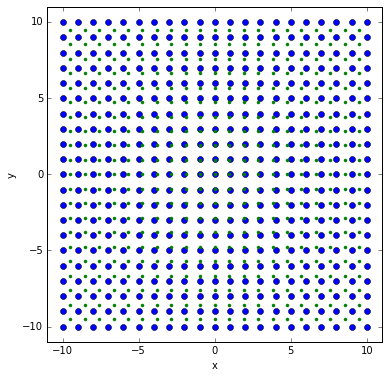

In [6]:
def trshow(tr, first_style='bo', last_style='g.', style='b.'):
    frames = list(tr.groupby('frame'))
    nframes = len(frames)
    for i, (fnum, pts) in enumerate(frames):
        if i == 0:
            sty = first_style
        elif i == nframes - 1:
            sty = last_style
        else:
            sty = style
        plot(pts.x, pts.y, sty)
    if 'particle' in tr.columns:
        for pid in tr.particle.unique():
            plot(tr.x[tr.particle == pid], 
                 tr.y[tr.particle == pid], 'r-')
    axis('equal'); ylim(-11, 11)
    xlabel('x')
    ylabel('y')

figure(figsize=(6, 6))
trshow(cg_original)

In the preceding plot, the large blue dots are the first frame, and the small green dots are the second frame.

### Linking without adaptive search

Next, we perform linking with a "small" `search_range` of 0.65. The computation finishes quickly but fails to link  the particles with the largest displacements, in the corners.

In [7]:
%%time
tracks_toosmall = trackpy.link_df(cg, 0.65)

Frame 1: 441 trajectories present
CPU times: user 271 ms, sys: 83 ms, total: 354 ms
Wall time: 252 ms


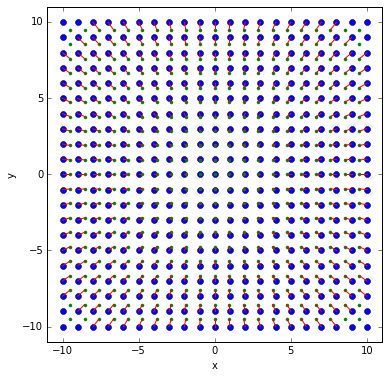

In [8]:
figure(figsize=(6, 6))
trshow(tracks_toosmall)

Seeing this problem, we increase `search_range` to 0.8. This computation also finishes quickly — by raising a `SubnetOversizeException`!

In [9]:
%%time
try:
    tracks_toobig = trackpy.link_df(cg, 0.8)
except trackpy.SubnetOversizeException:
    print('Failed!!')

Frame 0: 441 trajectories present
Failed!!
CPU times: user 16.2 ms, sys: 24.7 ms, total: 40.9 ms
Wall time: 14.8 ms


By trial and error (or some trigonometry), we *can* find a value of `search_range` that works for this movie. But it requires more than a little patience:

In [10]:
%%time
# Warning: takes several minutes!
tracks_regular = trackpy.link_df(cg, 0.75)

Frame 1: 441 trajectories present
CPU times: user 10min 39s, sys: 780 ms, total: 10min 40s
Wall time: 10min 39s


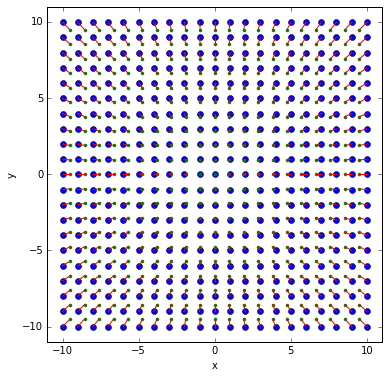

In [11]:
figure(figsize=(6, 6))
trshow(tracks_regular)

As printed above, it took several minutes to track just 441 particles in 2 frames. However, the result is correct, as shown by the plot, and by checking the duration of all the computed tracks:

In [12]:
tracks_regular.groupby('particle').particle.count().value_counts()

2    441
Name: particle, dtype: int64

This result indicates that there are 441 tracks that last for 2 frames, and no tracks that last for 1 frame, which would represent unlinked particles. So linking was successful, but at great cost.

### Linking with adaptive search

Since we know this movie is tricky, we choose a very fine `adaptive_step` — just 1% per iteration. But we can choose an irresponsibly large `search_range` of 0.95 — almost the spacing between particles!

In [13]:
%%time
tracks_adaptive = trackpy.link_df(cg, 0.95, adaptive_stop=0.56, adaptive_step=0.99)

Frame 1: 441 trajectories present
CPU times: user 133 ms, sys: 42 ms, total: 175 ms
Wall time: 122 ms


With adaptive search enabled, we can obtain the correct results more than an order of magnitude faster than we could with the single value of `search_range` we found by hand. Almost as importantly, this computation was not preceded by rounds of trial and error to select `search_range`.

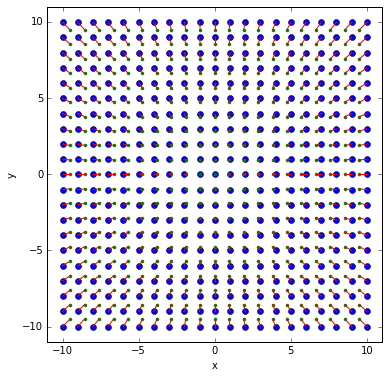

In [14]:
figure(figsize=(6, 6))
trshow(tracks_adaptive)

Both the plot and our check of track lengths show that the result is correct.

In [15]:
tracks_adaptive.groupby('particle').particle.count().value_counts()

2    441
Name: particle, dtype: int64

### A final note

As discussed above, adaptive search is not magic, and it may create the false impression that bad data are trackable. Until you are confident that you're using adaptive search properly, it's a good idea to pay attention to the output to make sure that the extra tracks you're getting are actually valid.